In [6]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt

https://www.scientifica.uk.com/learning-zone/how-to-compute-%CE%B4f-f-from-calcium-imaging-data

# **dF/F₀ Normalization: Using the Neuropil to Get Better Cell Fluorescence Estimates**

Calcium imaging provides a window into the activity of neurons, but raw fluorescence signals are often influenced by baseline fluctuations and background activity from the surrounding tissue. To make these signals interpretable, researchers compute dF/F₀, which represents the fractional change in fluorescence relative to a resting baseline. This transformation highlights calcium transients while minimizing slow drift and background noise.

In this module, you will walk through the core steps for computing dF/F₀ from a single-cell calcium imaging dataset. The workflow includes subtracting the neuropil contribution, estimating a stable baseline (F₀), and using spatial masks to define the cell and its surrounding region. All steps are implemented using just three Python libraries: numpy, scikit-image, and matplotlib.

## **Section 1: Computing dF/F₀ with Neuropil Subtraction (Using NumPy)**

This section focuses on the main transformation used in calcium imaging: computing the relative change in fluorescence, or dF/F₀. The goal is to produce a signal that represents meaningful activity changes, while removing contamination from surrounding neuropil tissue. You will start with raw fluorescence traces from the soma and its surrounding neuropil, then subtract a scaled neuropil signal before normalizing the result using a baseline F₀. These operations are implemented with numpy, allowing for clean and efficient processing of time-series data.

**Subsections**

- **Neuropil Subtraction Using Vectorized NumPy Operations**
Subtract a scaled version of the neuropil trace from the raw fluorescence trace to isolate a cleaner signal.

- **Apply Computed F₀ for Normalization**
Normalize the corrected signal using a dynamic F₀ value obtained from baseline estimation.

- **Visualize Raw, Corrected, and Normalized Traces**
Use matplotlib to plot each step of the transformation pipeline and observe how the signal improves with processing.

**Exercise** Load the data and masks

Load the image stack and binary masks using `tifffile` and `numpy`.

In [4]:
data = tifffile.imread('data/cropped_bottom_neuron_2000frames.tif')
cell_mask = np.load('data/cell_mask_small.npy')
neuropil_mask = np.load('data/neuropil_mask_thin_annulus.npy')

In [5]:
data.shape, cell_mask.shape, neuropil_mask.shape

((2000, 11, 15), (11, 15), (11, 15))

Plotting

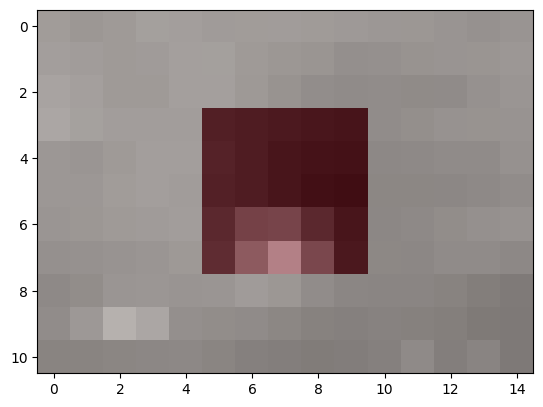

In [9]:
plt.imshow(data.mean(axis=0), cmap='gray')
plt.imshow(cell_mask, cmap='Reds', alpha=0.5)

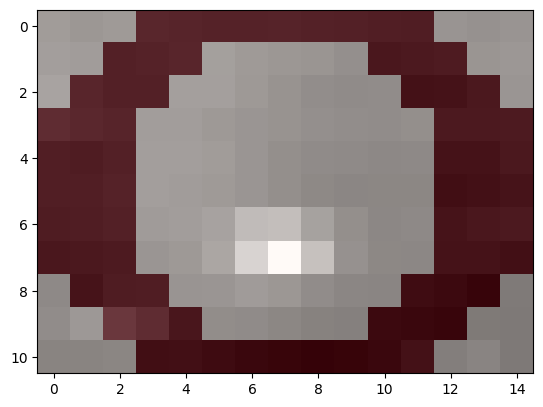

In [10]:
plt.imshow(data.mean(axis=0), cmap='gray')
plt.imshow(neuropil_mask, cmap='Reds', alpha=0.5)

**Exercise** Extract the flourescence time series

Use the binary masks to extract average pixel intensities across time.

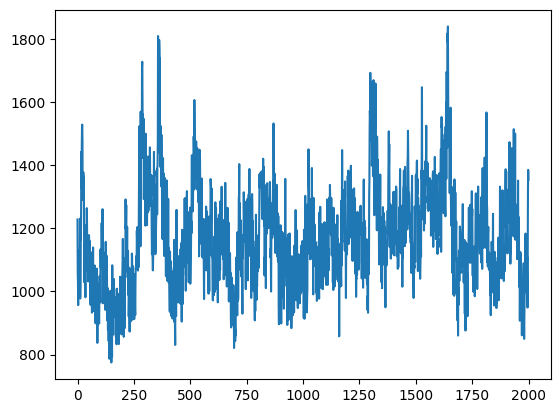

In [28]:
cell_trace = data[:, cell_mask]
cell_trace = np.mean(cell_trace, axis=1)
plt.plot(cell_trace)

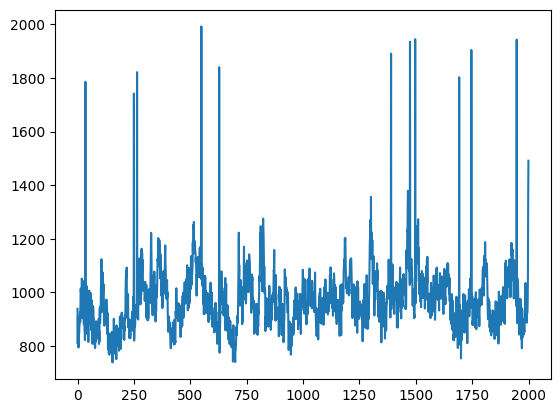

In [29]:
neuropil_trace = data[:, neuropil_mask]
neuropil_trace = np.mean(neuropil_trace, axis=1)
plt.plot(neuropil_trace)

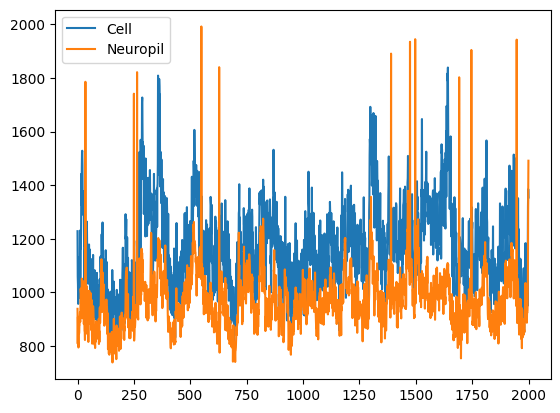

In [30]:
plt.plot(cell_trace, label='Cell')
plt.plot(neuropil_trace, label='Neuropil')
plt.legend();

Neuropil trace seems to be affected by outliers coming from few bright pixels inside the neuropil mask. Let us use median to see if there is any change

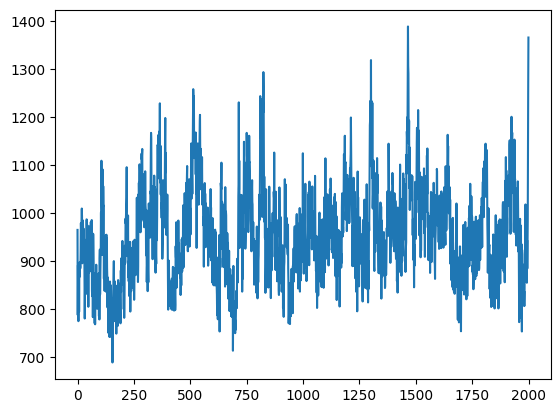

In [31]:
neuropil_trace = data[:, neuropil_mask]
neuropil_trace = np.median(neuropil_trace, axis=1)
plt.plot(neuropil_trace)

**Exercise** Compute df 

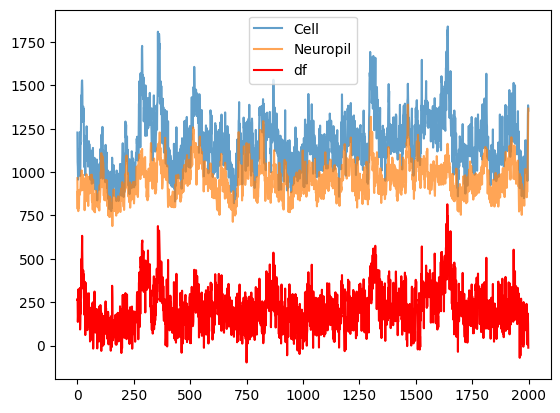

In [32]:
r = 1.0
df = cell_trace - r * neuropil_trace

plt.plot(cell_trace, alpha=0.7, label='Cell')
plt.plot(neuropil_trace, alpha=0.7, label='Neuropil')
plt.plot(df, color='red', label='df')
plt.legend();

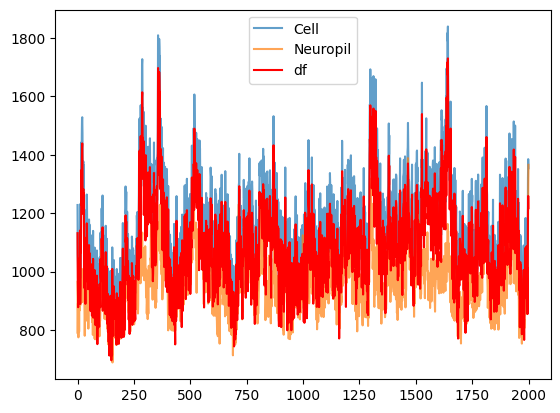

In [33]:
r = 0.1
df = cell_trace - r * neuropil_trace

plt.plot(cell_trace, alpha=0.7, label='Cell')
plt.plot(neuropil_trace, alpha=0.7, label='Neuropil')
plt.plot(df, color='red', label='df')
plt.legend();

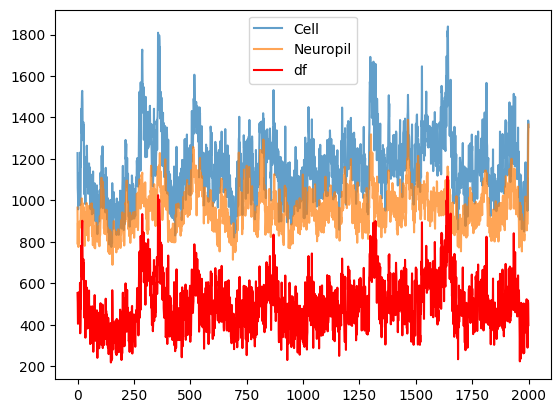

In [34]:
r = 0.7
df = cell_trace - r * neuropil_trace

plt.plot(cell_trace, alpha=0.7, label='Cell')
plt.plot(neuropil_trace, alpha=0.7, label='Neuropil')
plt.plot(df, color='red', label='df')
plt.legend();

**Apply computed F₀ for normalization**

**Exercise** Estimate global F₀ 

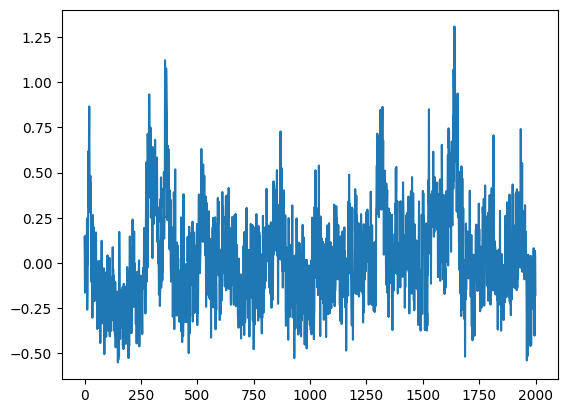

In [40]:
f0 = np.median(df)
dff = (df - f0) / f0

plt.plot(dff)

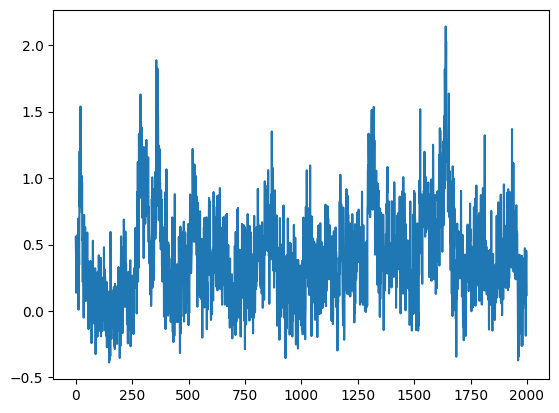

In [41]:
f0 = np.percentile(df, 10)
dff = (df - f0) / f0

plt.plot(dff)

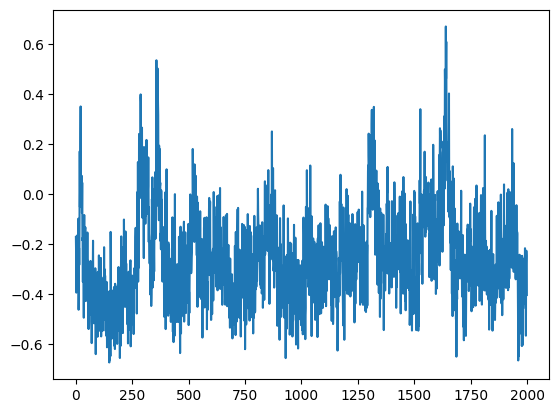

In [42]:
f0 = np.percentile(df, 90)
dff = (df - f0) / f0

plt.plot(dff)

## **Section 2: Estimating Baseline Fluorescence (F₀) Using Moving Averages**

Before calculating dF/F₀, it is necessary to estimate the cell’s baseline fluorescence, referred to as F₀. This value should reflect the resting fluorescence level of the cell in the absence of activity. A poor F₀ estimate can either inflate or suppress neural transients, making activity harder to detect. In this section, you will explore methods for calculating a stable and adaptive baseline using moving averages and percentile-based filters. These methods are designed to track slow shifts in baseline while remaining robust to fast activity events.


**Subsections:**
- **Rolling Window Percentile-Based Baseline**  
  Use a sliding window to compute a low percentile value over time, which helps avoid bias from transient events.
  
- **Exponential or Causal Moving Averages**  
  Apply exponential smoothing to adaptively follow the baseline, offering a trade-off between responsiveness and stability.
  
- **Overlay and Compare Methods Visually**  
  Plot multiple baseline estimates alongside the original trace to visually compare how different methods behave under drift and noise.

## **Section 3: Estimating Baseline Fluorescence (F₀) Using Moving Averages**

To compute accurate fluorescence signals, you must first define the spatial regions that correspond to the neuron and the surrounding neuropil. Even in single-cell recordings, nearby processes and background structures contribute to fluorescence measurements. In this section, you will use image processing tools from scikit-image to create masks for both the soma and a ring-shaped neuropil region. These masks can then be applied to an image stack to extract mean fluorescence signals over time.

**Subsections:** 
- **Preprocessing and Image Enhancement**  
  Improve the visibility of the neuron using filtering and normalization techniques prior to segmentation.
  
- **Cell ROI Segmentation**  
  Use thresholding and morphological operations to generate a mask that captures the cell body accurately.
  
- **Neuropil Mask Generation**  
  Create a neuropil mask by dilating the soma and subtracting its core region, ensuring no overlap with the actual cell.

- **Extract Mean Fluorescence for Cell and Neuropil**
  Use the generated masks to compute pixel-averaged fluorescence traces across the time series.